<div style="text-align: center;">
    <strong><em>Histopathologic Cancer Detection</em></strong>
</div>

In [3]:
!pip install -r Cancer_Detection/requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [7]:
train_path = "Cancer_Detection/data/train"
test_path = "Cancer_Detection/data/test"
train_data = pd.read_csv("Cancer_Detection/data/train_labels.csv")

In [8]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Define the train and valid data
train_data["label"] = train_data["label"].astype(float)

# Split the data into train and validation
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [17]:
# Image transformations
std_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 2425 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      176020 non-null  object 
 1   label   176020 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.0+ MB
                                              id  label
2425    6e4e15501c5b5d76de47a606bd5adcc31259bf28    0.0
41861   b82a02a1328853929fb59366f45f25041edf6997    1.0
186299  7b80456230e98ca1671a2645bdf4bb1fddaf7ef2    0.0
54730   db24a0b08e62c7795874b839bd8e1feb981a1c27    1.0
31665   ac4901d3dee2875e0619461fcf6495e0db78eecd    0.0
               label
count  176020.000000
mean        0.405005
std         0.490894
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


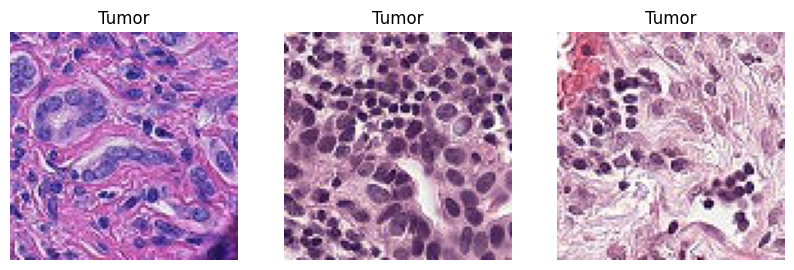

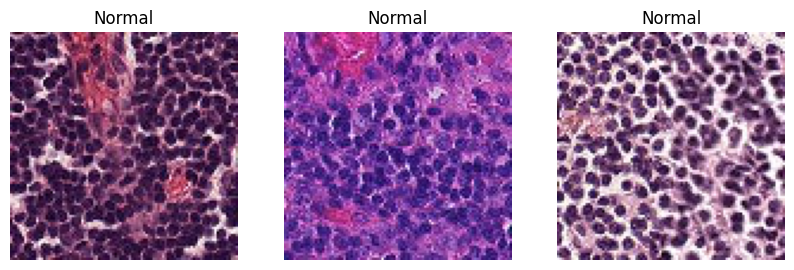

In [18]:
# Perform EDA
train_data.info()
print(train_data.head())
print(train_data.describe())

# Remove unnecessary data
train_data.drop_duplicates()
train_data = train_data.dropna(axis=0, subset=["label"])

# Remove unnecessary data from valid data
valid_data.drop_duplicates()
valid_data = valid_data.dropna(axis=0, subset=["label"])

# Visual data
sample_tumor_ids = train_data[train_data["label"] == 1]["id"].sample(n=3).values
sample_normal_ids = train_data[train_data["label"] == 0]["id"].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + ".tif")
    tumor_images.append(Image.open(image_path))

normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + ".tif")
    normal_images.append(Image.open(image_path))

plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title("Tumor")
    plt.axis("off")
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title("Normal")
    plt.axis("off")
plt.show()



In [19]:
# Data definition
class TumorDataset(Dataset):
    def __init__(self, image_dir, label_df, transform=None):
        self.image_dir = image_dir
        self.labels = label_df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx]["id"]
        label = self.labels.iloc[idx]["label"]
        img_path = os.path.join(self.image_dir, img_id) + ".tif"
        imageLoaded = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.float32)
        if self.transform:
            imageLoaded = self.transform(imageLoaded)
        return imageLoaded, label


train_dataset = TumorDataset(image_dir=train_path, label_df=train_data, transform=std_transform)
valid_dataset = TumorDataset(image_dir=train_path, label_df=valid_data, transform=std_transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True, num_workers=16, pin_memory=True
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=1024, shuffle=False, num_workers=16, pin_memory=True
)


In [20]:
# Model Definition
class ExtendedResNet50(nn.Module):
    def __init__(self, weights=True):
        super(ExtendedResNet50, self).__init__()
        self.resnet = models.resnet50(weights='IMAGENET1K_V2' if weights else None)
        in_features = self.resnet.fc.in_features

        # Replace the original fully connected layer with an identity layer
        self.resnet.fc = nn.Identity()

        self.new_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
        )

    def forward(self, x):
        rx = self.resnet(x)
        output = self.new_fc(rx)
        return output

In [21]:
# Instantiate the model and move it to the selected device
resnet_model_binary = ExtendedResNet50(weights=True)

#
# Define the loss function and optimizer
resnet_model_binary.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model_binary.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 18
resnet_model_binary.train()  # Set model to training mode

scaler = GradScaler('cuda')

In [22]:
# Train on data and validate
def predict(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            all_outputs.extend(sigmoid_outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_outputs)


for epoch in range(num_epochs):
    resnet_model_binary.train()
    running_loss = 0.0
    data_iter = iter(train_dataloader)

    # Prepare the first batch
    next_batch = next(data_iter)
    next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

    for i in range(len(train_dataloader)):
        batch = next_batch
        images, labels = batch

        if i + 1 != len(train_dataloader):
            next_batch = next(data_iter)
            next_batch = [tensor.to(device, non_blocking=True) for tensor in next_batch]

        optimizer.zero_grad()

        with autocast(device.type):
            outputs = resnet_model_binary(images)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Validation step
    val_labels, val_outputs = predict(resnet_model_binary, valid_dataloader)
    roc_auc = roc_auc_score(val_labels, val_outputs)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}, ROC AUC: {roc_auc:.4f}")

print("Training finished.")

Epoch [1/18], Loss: 0.1665, ROC AUC: 0.9896
Epoch [2/18], Loss: 0.0811, ROC AUC: 0.9929
Epoch [3/18], Loss: 0.0531, ROC AUC: 0.9923
Epoch [4/18], Loss: 0.0413, ROC AUC: 0.9919
Epoch [5/18], Loss: 0.0311, ROC AUC: 0.9927
Epoch [6/18], Loss: 0.0091, ROC AUC: 0.9964
Epoch [7/18], Loss: 0.0028, ROC AUC: 0.9963
Epoch [8/18], Loss: 0.0017, ROC AUC: 0.9962
Epoch [9/18], Loss: 0.0013, ROC AUC: 0.9961
Epoch [10/18], Loss: 0.0011, ROC AUC: 0.9960
Epoch [11/18], Loss: 0.0010, ROC AUC: 0.9960
Epoch [12/18], Loss: 0.0009, ROC AUC: 0.9960
Epoch [13/18], Loss: 0.0009, ROC AUC: 0.9960
Epoch [14/18], Loss: 0.0009, ROC AUC: 0.9960
Epoch [15/18], Loss: 0.0009, ROC AUC: 0.9960
Epoch [16/18], Loss: 0.0008, ROC AUC: 0.9960
Epoch [17/18], Loss: 0.0009, ROC AUC: 0.9960
Epoch [18/18], Loss: 0.0008, ROC AUC: 0.9960
Training finished.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.82].


tensor([[ -7.6600],
        [ -8.3262],
        [-11.1807]], device='cuda:0')


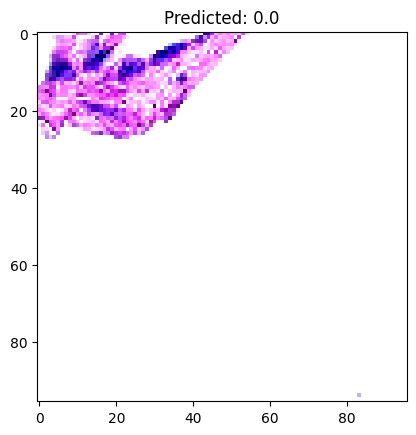

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.82].


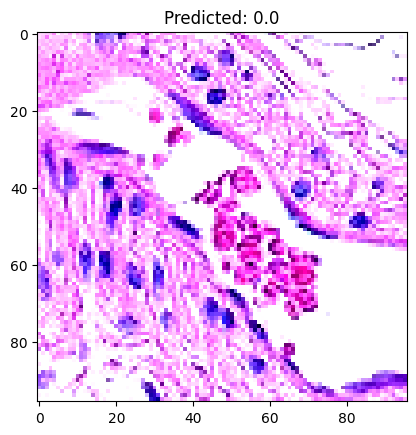

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.82].


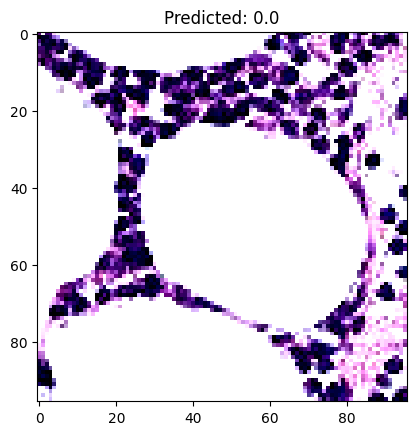

In [23]:
# Test Images
test_data = pd.read_csv("Cancer_Detection/data/sample_submission.csv")
test_dataset = TumorDataset(image_dir=test_path, label_df=test_data, transform=std_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=16, pin_memory=True)

# Function to unnormalize and plot images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Set model to evaluation mode
resnet_model_binary.to(device)
resnet_model_binary.eval()

# Get three items from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Select three images
images, labels = images[:3], labels[:3]

# Move the images to the appropriate device
images = images.to(device)

# Predict the labels for these images
with torch.no_grad():
    outputs = resnet_model_binary(images)
    print(outputs)
    predicted_labels = torch.round(torch.sigmoid(outputs)).cpu().numpy()

# Move the images back to CPU for visualization
images = images.cpu()

# Plot the images and their predicted labels
for i in range(3):
    imshow(images[i], title=f'Predicted: {predicted_labels[i][0]}')

